<a href="https://colab.research.google.com/github/sajeebju/Salt/blob/main/Salt_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from tqdm.notebook import tqdm

In [7]:
im_width = 128
im_height = 128
border = 5
path_train = "/content/drive/MyDrive/Python/TGS/train/images/"
path_train_masks = "/content/drive/MyDrive/Python/TGS/train/masks/"

In [8]:
try:
    ids = next(os.walk(path_train))[2]
    masks = next(os.walk(path_train_masks))[2]
    print("No. of images = ", len(ids))
    print("No. of masks = ", len(masks))
except StopIteration:
    print("One or both of the directories do not exist or are empty.")


No. of images =  4000
No. of masks =  4000


In [9]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
for n, i in tqdm(enumerate(ids), total=len(ids)):
    images = load_img(path_train + i, color_mode='grayscale')  # updated argument
    img = img_to_array(images)
    img = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = img / 255.0

  0%|          | 0/4000 [00:00<?, ?it/s]

In [12]:
for n, i in tqdm(enumerate(ids), total=len(ids)):
    masks_data = load_img(path_train_masks + i, color_mode='grayscale')
    mask = img_to_array(masks_data)
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    y[n] = mask / 255.0


  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Salt')

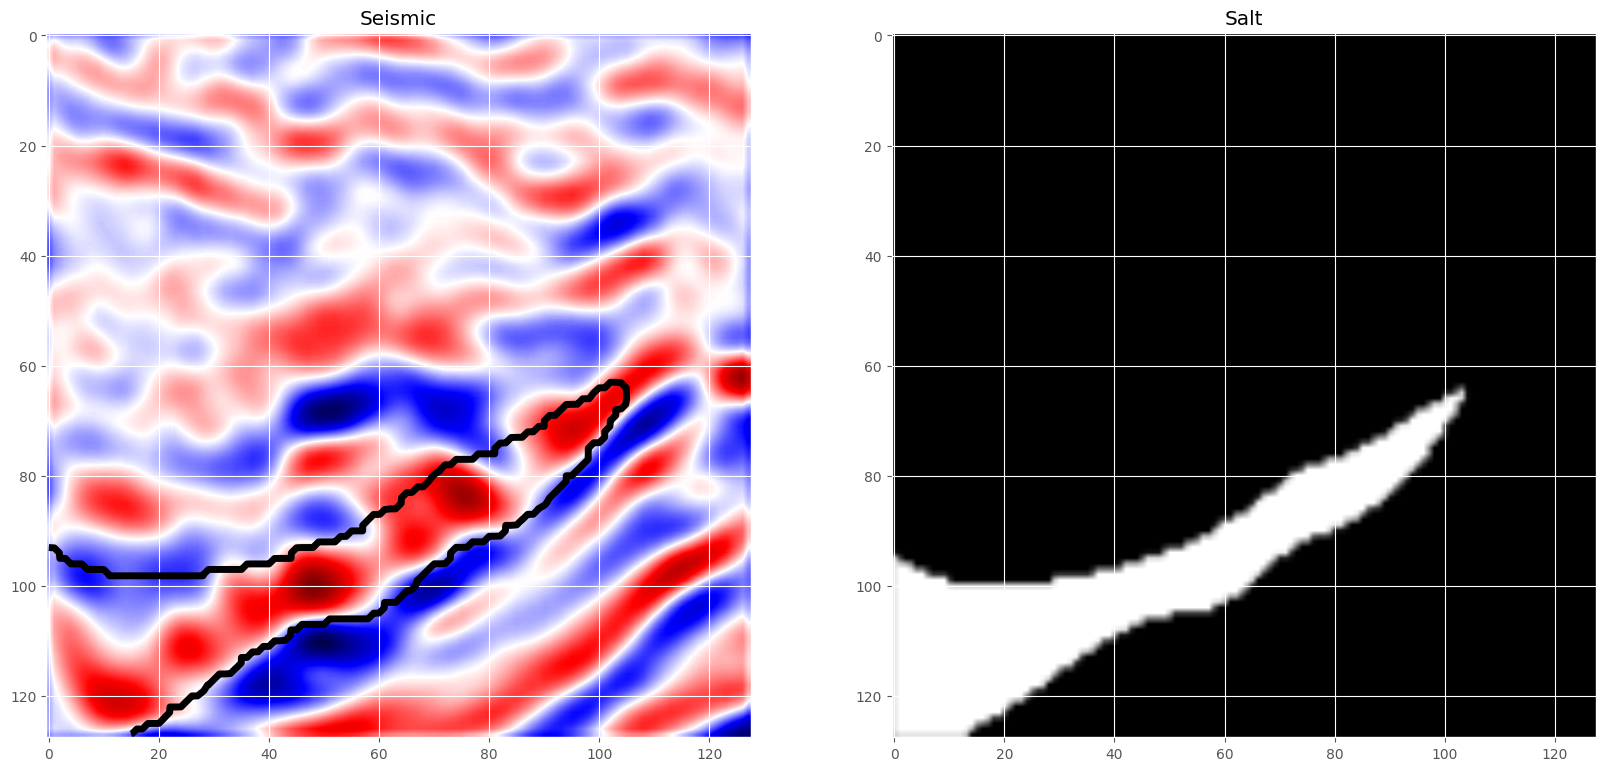

In [17]:
ix = random.randint(0, len(X_train))

# Indicating salt
has_mask = y_train[ix].max() > 0
fig, ax = plt.subplots(1, 2, figsize = (20, 15))
ax[0].imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')

#if salt
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax[1].set_title('Salt')

In [18]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
kernel_initializer = 'he_normal', padding = 'same')(input_tensor)

    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


In [19]:
def unet_model(input_img, dropout = 0.1):
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_img)
  c1 = BatchNormalization()(c1)
  c1 = tf.keras.layers.Dropout(dropout)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = tf.keras.layers.Dropout(dropout)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = tf.keras.layers.Dropout(dropout)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  c3 = BatchNormalization()(c3)

  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = BatchNormalization()(c4)
  c4 = tf.keras.layers.Dropout(dropout)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  c4 = BatchNormalization()(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = BatchNormalization()(c5)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
  c5 = BatchNormalization()(c5)


  #Expansive path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = BatchNormalization()(c6)
  c6 = tf.keras.layers.Dropout(dropout)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  c6 = BatchNormalization()(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = BatchNormalization()(c7)
  c7 = tf.keras.layers.Dropout(dropout)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  c7 = BatchNormalization()(c7)


  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = BatchNormalization()(c8)
  c8 = tf.keras.layers.Dropout(dropout)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  c8 = BatchNormalization()(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = BatchNormalization()(c9)
  c9 = tf.keras.layers.Dropout(dropout)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  c9 = BatchNormalization()(c9)


  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[input_img], outputs=[outputs])

  return model

In [20]:
input_img = Input((im_height, im_width, 1), name='img')

In [21]:
model = unet_model(input_img, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
callbacks2 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Python/TGS/model-tgs-salt.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [23]:
results2 = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks2, validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.4918 - loss: -157.9725
Epoch 1: val_loss improved from inf to -7066.54492, saving model to /content/drive/MyDrive/Python/TGS/model-tgs-salt.weights.h5
113/113 ━━━━━━━━━━━━━━━━━━━━ 75s 338ms/step - accuracy: 0.4924 - loss: -159.0549 - val_accuracy: 8.8638e-04 - val_loss: -7066.5449 - learning_rate: 0.0010
Epoch 2/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6555 - loss: -595.9704
Epoch 2: val_loss did not improve from -7066.54492
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.6555 - loss: -597.6719 - val_accuracy: 0.0681 - val_loss: -1620.0966 - learning_rate: 0.0010
Epoch 3/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6347 - loss: -1073.7461
Epoch 3: val_loss did not improve from -7066.54492
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.6347 - loss: -1075.9883 - val_accuracy: 0.2796 - val_loss: -2302.2385 - learning_rate: 0.0010
Epoch 4/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 

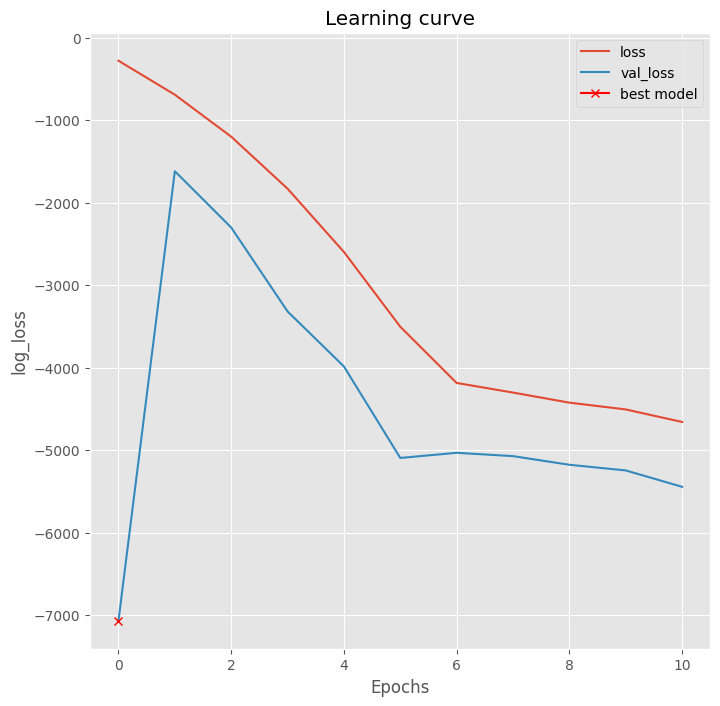

In [24]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results2.history["loss"], label="loss")
plt.plot(results2.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results2.history["val_loss"]), np.min(results2.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [25]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5454 - loss: -5930.0444


[-5444.24560546875, 0.555411696434021]

In [26]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [40]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');


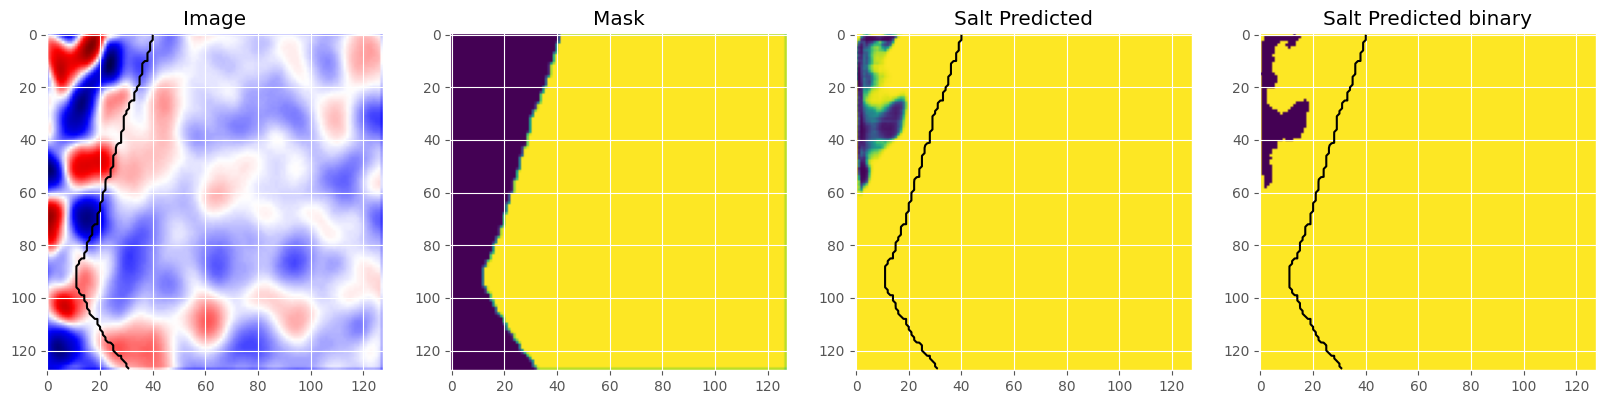

In [41]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)


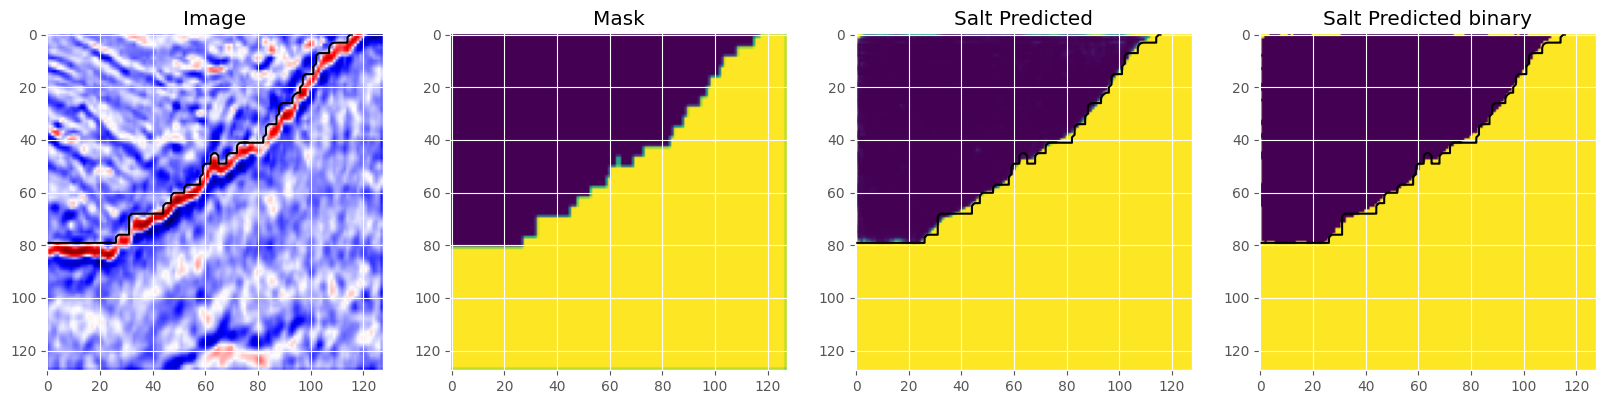

In [42]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=48)

In [ ]:
model.save("/content/drive/MyDrive/Python/TGS/Salt_Detection_57.h5")